In [11]:
import pandas as pd
import os
import scipy
from nibabel import freesurfer as fs
import numpy as np
import nxviz as nv
import networkx as nx
from nxviz import lines, utils, layouts, nodes, plots, edges, encodings
from random import choice
from nxviz import encodings as aes
from typing import Callable, Dict, Hashable, Tuple, Optional
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
from functools import partial
from matplotlib.cm import get_cmap
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from nxviz.geometry import circos_radius, item_theta
from nxviz.polcart import to_cartesian
from nxviz.utils import group_and_sort
from scipy import io

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(hexbin)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In addition: Warning message:
package ‘ggnewscale’ was built under R version 4.3.3 


## Load Glasser parcellation for right hemisphere

In [6]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices.byteswap().newbyteorder()
glasser180_right_ctab = glasser180_right_ctab.byteswap().newbyteorder()
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [7]:
# Read in OCDA modules
ocda_modules_glasser180_right = pd.read_csv("/Users/abry4213/github/OverlappingCommunityDetection_HCP/Results/table_of_modules_AF_renamed.csv")
ocda_modules_glasser180_right.columns = ["Glasser_RH_ROI", "module", "overlapping"]

# Load module orders
module_orders = pd.read_csv("module_order.csv")

In [8]:
%%R -i ocda_modules_glasser180_right,module_orders -o ocda_modules_glasser180_right

# Tidy data
ocda_modules_glasser180_right <- ocda_modules_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module))%>% 
  filter(module != "Unassigned")

## Load Yeo 2011 7-network parcellation

In [9]:
yeo7_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot"
yeo7_right_vertices, yeo7_right_ctab, yeo7_right_names = fs.read_annot(yeo7_right_file)

yeo7_right_vertices = yeo7_right_vertices.byteswap().newbyteorder()
yeo7_right_ctab = yeo7_right_ctab.byteswap().newbyteorder()
yeo7_right_names = [name.decode() for name in yeo7_right_names]

# Create Yeo 7 right hemi lookup table
yeo7_right_LUT = pd.read_csv("yeo7_lookup.csv")

# Convert yeo17 array to dataframe
yeo7_right_df = pd.DataFrame({'index': yeo7_right_vertices, 'vertex_number': np.arange(0, len(yeo7_right_vertices))})
yeo7_right_df['Yeo7_RH_ROI'] = yeo7_right_df['index'].map(yeo7_right_LUT.set_index('index')['Yeo7_RH_ROI'])

# Drop index
yeo7_right_df = yeo7_right_df.drop(columns=['index'])


## Merge all the data!

In [18]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, ocda_modules_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with Yeo 7 networks
merged_df = pd.merge(merged_df, yeo7_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???" and Yeo7_RH_ROI != "???"')

## Visualize connectivity data between overlapping modules and the 6 structural networks

In [12]:
# Load in connectivity data
RH_connectivity_data = pd.DataFrame(scipy.io.loadmat('../Results/RH.mat')['RH'])

region_labels = pd.read_csv("../Results/brain_area_labels.csv", header=None)
region_labels.columns = ["region_index", "Glasser_RH_ROI"]
# RH_connectivity_data.columns = region_labels.Glasser_RH_ROI[0:180]

In [13]:
%%R -i region_labels,RH_connectivity_data,ocda_modules_glasser180_right -o RH_connectivity_data_tidy

regions_included <- ocda_modules_glasser180_right$Glasser_RH_ROI

region_labels_tidy <- region_labels %>%
    pull(Glasser_RH_ROI)

RH_connectivity_data_tidy <- RH_connectivity_data
colnames(RH_connectivity_data_tidy) <- rownames(RH_connectivity_data_tidy) <- region_labels_tidy[1:180]

module_order_for_connectogram <- c("Anterior frontal + cingulate and adj. cortex", 
                                   "Cingulate and adj. cortex + visual",
                                   "Visual + fronto-parietal",
                                   "Fronto-parietal + somatomotor",
                                   "Somatomotor + insula and post. temporal",
                                   "Insula and post. temporal + visual",
                                   "Anterior frontal",
                                   "Cingulate and adj. cortex",
                                   "Visual",
                                   "Fronto-parietal",
                                   "Somatomotor",
                                   "Insula and post. temporal")

RH_connectivity_data_tidy <- RH_connectivity_data_tidy %>%
    rownames_to_column(var="region_from") %>%
    pivot_longer(-region_from, names_to="region_to", values_to="SC") %>% 
    filter(region_from != region_to) %>% 
    left_join(., ocda_modules_glasser180_right, by=c("region_from"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_from" = "module", "overlapping_from" = "overlapping") %>%
    left_join(., ocda_modules_glasser180_right, by=c("region_to"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_to" = "module", "overlapping_to" = "overlapping")  %>%
    filter(overlapping_from=="Overlapping", region_from %in% regions_included, region_to %in% regions_included) %>%
    mutate(overlapping_to = factor(overlapping_to, levels=c("Overlapping", "Non-overlapping"))) %>%
    arrange(overlapping_to, module_to, region_to) %>% 
    mutate(module_to_num = as.numeric(factor(module_to, levels = module_order_for_connectogram)))

In [14]:
# Function to color nodes by group
def group_colormap(data: pd.Series):
    # cmap = {"Anterior frontal": "#f8766d", 
    #         "Anterior frontal + cingulate and adj. cortex": "#de8c00", 
    #         "Cingulate and adj. cortex": "#b79f00",
    #         "Cingulate and adj. cortex + visual": "#7cae00",
    #         "Visual": "#00ba38",
    #         "Visual + fronto-parietal": "#00c08b",
    #         "Fronto-parietal": "#00bfc4", 
    #         "Fronto-parietal + somatomotor": "#00b4f0",
    #         "Somatomotor": "#619cff",
    #         "Somatomotor + insula and post. temporal": "#c77cff",
    #         "Insula and post. temporal": "#f564e3",
    #         "Insula and post. temporal + visual": "#ff64b0"}

    cmap = {1: "#de8c00", 
            2: "#7cae00", 
            3: "#00c08b",
            4: "#00b4f0",
            5: "#c77cff",
            6: "#ff64b0",
            7: "#f8766d", 
            8: "#b79f00",
            9: "#00ba38",
            10: "#00bfc4",
            11: "#619cff",
            12: "#f564e3"}
    return data.apply(lambda x: cmap.get(x))
    
# Custom edge coloring functions
def continuous_color_func(val, cmap, data: pd.Series, vmin, vmax):
    """Return RGBA of a value.

    ## Parameters

    - `val`: Value to convert to RGBA
    - `cmap`: A Matplotlib cmap
    - `data`: Pandas series.
    """
    norm = Normalize(vmin=vmin, vmax=vmax)
    return cmap(norm(val))

def color_func(data: pd.Series, cmap, vmin, vmax) -> Callable:
    """Return a color function that takes in a value and returns an RGB(A) tuple.

    This will do the mapping to the continuous and discrete color functions.
    """
    func = continuous_color_func
    return partial(func, cmap=cmap, data=data, vmin=vmin, vmax=vmax)

def data_color(data: pd.Series, ref_data: pd.Series, cmap, vmin, vmax) -> pd.Series:
    """Return iterable of colors for a given data.

    `cfunc` gives users the ability to customize the color mapping of a node.
    The only thing that we expect is that it takes in a value
    and returns a matplotlib-compatible RGB(A) tuple or hexadecimal value.

    The function takes in `ref_data`
    which is used to determine important colormap values (such as boundaries).
    That colormap is then applied to the actual `data`.

    ## Parameters

    - `data`: The data on which to map colors.
    - `ref_data`: The data on which the colormap is constructed.
    """
    cfunc = color_func(ref_data, cmap, vmin, vmax)
    return data.apply(cfunc)

def edge_colors_cat(
    et: pd.DataFrame,
    nt: pd.DataFrame,
    cmap,
    color_by: Hashable,
    node_color_by: Hashable,
):
    """Default edge line color function."""
    if color_by in ("source_node_color", "target_node_color"):
        edge_select_by = color_by.split("_")[0]
        return data_color(
            et[edge_select_by].apply(nt[node_color_by].get),
            nt[node_color_by], cmap=cmap, vmin=1, vmax=1)
    elif color_by:
        return data_color(et[color_by], et[color_by], cmap=cmap, vmin=1, vmax=1)
    return pd.Series(["black"] * len(et), name="color_by")

def edge_colors(
    et: pd.DataFrame,
    nt: pd.DataFrame,
    cmap,
    vmin,
    vmax,
    color_by: Hashable,
    node_color_by: Hashable,
):
    """Default edge line color function."""
    if color_by in ("source_node_color", "target_node_color"):
        edge_select_by = color_by.split("_")[0]
        return data_color(
            et[edge_select_by].apply(nt[node_color_by].get),
            nt[node_color_by], cmap=cmap, vmin=vmin, vmax=vmax)
    elif color_by:
        return data_color(et[color_by], et[color_by], cmap=cmap, vmin=vmin, vmax=vmax)
    return pd.Series(["black"] * len(et), name="color_by")



In [15]:

# Define a formatting function to add a minus sign to the hypo-connectivity labels
def format_func(value):
    return f'-{value:.1f}'

def plot_individual_chord_graph(G, my_cmap, group_var, vmin, vmax, edge_alpha=0.7):
    # Customize node styling
    ax = plt.gca()

    nt = utils.node_table(G)
    # pos = layouts.circos(nt, group_by=group_var, sort_by=group_var)
    
    nodes_list = list(nt.index)
    radius = circos_radius(len(nodes_list))
    pos = {} 
    for i in range(11):
        node = nt.index[i]
        # theta = i * 2 * np.pi / len(nodes_list)
        theta = i * 17.6 * np.pi / len(nodes_list)
        x, y = to_cartesian(r=radius, theta=theta+0.015)
        pos[node] = np.array([x, y])
    for i in np.arange(11, len(nodes_list)):
        node = nt.index[i]
        theta = i * 1.05 * np.pi / len(nodes_list)
        x, y = to_cartesian(r=radius, theta=theta+2.95)
        pos[node] = np.array([x, y])

    # Define nodes and corresponding lobe colors
    node_color = group_colormap(nt[group_var])
    alpha = nodes.transparency(nt, alpha_by=None)
    size = nodes.node_size(nt, size_by=None)
    patches = nodes.node_glyphs(
        nt, pos, node_color=node_color, alpha=alpha, size=size)
    for patch in patches:
        ax.add_patch(patch)
        
    # Customize edge styling
    et = utils.edge_table(G)
    # edge_color = group_colormap(nt[group_var])
    edge_color = edge_colors(et, nt=None, color_by="weight", node_color_by=None, cmap=my_cmap, vmin=vmin, vmax=vmax)
    lw = pd.Series([2]*et.shape[0])
    edge_alpha = pd.Series(preprocessing.minmax_scale(np.absolute(et["weight"]), feature_range=(0.1, 0.6), axis=0, copy=True))
    edge_lw = pd.Series(preprocessing.minmax_scale(np.absolute(et["weight"]), feature_range=(0.1, 1), axis=0, copy=True))
    patches = lines.circos(
        et, pos, edge_color=edge_color, alpha=edge_alpha, lw=edge_lw, aes_kw={"fc": "none"}
    )
    for patch in patches:
        ax.add_patch(patch)
        
    plots.rescale(G)
    plots.aspect_equal()
    plots.despine()


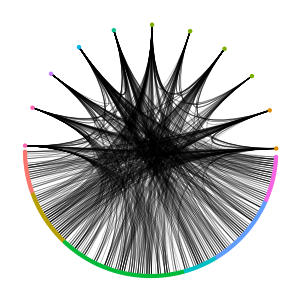

In [16]:
G_SC = nx.DiGraph(name = "Structural Connectivity")
RH_connectivity_data_array = RH_connectivity_data_tidy.filter(["region_from", "region_to", "SC", "module_from"], axis=1).to_numpy()

# Add all nodes
nodes_list = RH_connectivity_data_tidy.region_to.unique()
G_SC.add_nodes_from(nodes_list)

for i in range(len(RH_connectivity_data_array)):
    connection = RH_connectivity_data_array[i]
    region_from = connection[0] # protein a node
    region_to = connection[1] # protein b node
    SC_value = connection[2] # score as weighted edge
    module_from = connection[3]
    
    # Add only high edges to G_hyper
    if SC_value > 0:
        G_SC.add_weighted_edges_from([(region_from,region_to,SC_value)])

# Add module to each node (region)
for n, d in G_SC.nodes(data=True):
    brain_region = n
    module_to_num = RH_connectivity_data_tidy.query("region_to == @brain_region")["module_to_num"][0]
    G_SC.nodes[n]["module_to_num"] = module_to_num

# Figure out edge color ranges to match
G_SC_et = utils.edge_table(G_SC)

# Figure out edge color ranges to match
vmin = G_SC_et.weight.min()
vmax = G_SC_et.weight.max()
a = np.array([[vmin,vmax]])

# Hyper plot
fig_SC, ax_SC = plt.subplots()

# Define my own LinearSegmentedColormap with just the color black
black_cmap = LinearSegmentedColormap('black', {'red':   ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'green': ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'blue':  ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0))})
 
#
plot_individual_chord_graph(G_SC, black_cmap, group_var="module_to_num", vmin=vmin, vmax=vmax)
fig_SC.tight_layout()
fig_SC.set_size_inches(3,3)
# fig_SC.savefig("../Plots/SC_connectogram.svg", dpi=300)


## How do the overlapping regions compare with the Yeo 2011 17-network functional atlas?

In [31]:
%%R -i merged_df,ocda_modules_glasser180_right

merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(overlapping=="Overlapping") %>%
    mutate(Yeo7_RH_ROI = ifelse(is.na(Yeo7_RH_ROI), "None", Yeo7_RH_ROI)) %>%
    filter(Yeo7_RH_ROI != "None") %>%
    group_by(module, Glasser_RH_ROI) %>% 
    mutate(num_voxels = n()) %>% 
    group_by(module, overlapping, Glasser_RH_ROI, Yeo7_RH_ROI) %>% 
    summarise(num_voxels_in_yeo7 = n(),
              prop_voxels_in_yeo7 = 100*num_voxels_in_yeo7/num_voxels) %>% 
    ungroup() %>%
    distinct() %>%
    complete(module, Glasser_RH_ROI, Yeo7_RH_ROI, fill=list(prop_voxels_in_yeo7=0)) %>% 
    semi_join(., ocda_modules_glasser180_right %>% dplyr::select(Glasser_RH_ROI, module)) %>%
    ungroup() %>% 
    mutate(Yeo7_RH_ROI = factor(Yeo7_RH_ROI, levels=rev(c("Visual", "Somatomotor", "Dorsal attention", "Ventral attention", "Limbic", "Frontoparietal", "Default"))),
           ROI_label_short = gsub("_ROI", "", gsub("R_", "", Glasser_RH_ROI))) %>%
    mutate(ROI_label_short = factor(ROI_label_short, levels = c("8BM", "9m", "PHA1", "POS2", "PeEc", "RSC", "PGs", "PFm", "PoI2", "A4", "A5"))) %>%
    ggplot(data=., mapping=aes(y=Yeo7_RH_ROI, x=ROI_label_short, fill=prop_voxels_in_yeo7)) +
    geom_tile(linewidth=0.5) +
    xlab("Brain Region") +
    ylab("Yeo 7-Network Area") +
    labs(fill="% Voxels in Network") +
    scale_fill_viridis_c() +
    theme(legend.position="bottom",
          strip.background = element_blank(),
          axis.text.y = element_text(size=14),
          axis.text.x = element_text(angle=45, hjust=1, size=12))
ggsave("../Plots/Overlapping_regions_vs_Yeo_atlas.svg", width=5, height=4, dpi=300, units="in")

`summarise()` has grouped output by 'module', 'overlapping', 'Glasser_RH_ROI',
'Yeo7_RH_ROI'. You can override using the `.groups` argument.
Joining with `by = join_by(module, Glasser_RH_ROI)`


In addition: Warning message:
Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [25]:
%%R -i merged_df,ocda_modules_glasser180_right

merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(overlapping=="Overlapping") %>% 
    distinct(Glasser_RH_ROI)

    Glasser_RH_ROI
33       R_PGs_ROI
36        R_A4_ROI
63       R_RSC_ROI
64      R_POS2_ROI
73       R_PFm_ROI
92       R_8BM_ROI
120       R_9m_ROI
149     R_PeEc_ROI
197     R_PoI2_ROI
356       R_A5_ROI
441     R_PHA1_ROI
